In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
product_attribute = pd.read_excel('/Users/fuqiaozhi/Desktop/UTD Semesters/Spring 2024/BUAN 6337/Conagra Cleaned Data/Product Attributes.xlsx')
fz_meat = pd.read_excel('/Users/fuqiaozhi/Desktop/UTD Semesters/Spring 2024/BUAN 6337/Conagra Data/Data/Fz_Rfg Substitute Meat_POS_2023.xlsx')

In [6]:
product_attribute.head()

,Product,UPC 13 digit,Aisle Name,Category Name,Sub-Category Name,Manufacturer Name,Brand Franchise Name,Brand Name,Package,Total Count,Total Ounces,Form,Flavor / Scent,Meat Source,Product Type,Type Of Meat Substituted,Type Of Substitute,Cooked Info
0,AL SAFA HALAL FROZEN BEEF HOTDOG 12.6 OZ - 062...,624967436101,AISLE-FROZEN MEAT/POULTRY/SEAFOOD,MEAT - FZ,FZ FRANKFURTERS,AL SAFA HALAL,AL SAFA HALAL,AL SAFA HALAL,VACUUM PACKED,8.0,12.6,NaN,REGULAR,BEEF,HOT DOG,NaN,NaN,NaN
1,AL SAFA HALAL FROZEN CHICKEN FRANKFURTER 12 OZ...,624967508101,AISLE-FROZEN MEAT/POULTRY/SEAFOOD,MEAT - FZ,FZ FRANKFURTERS,AL SAFA HALAL,AL SAFA HALAL,AL SAFA HALAL,VACUUM PACKED,6.0,12.0,NaN,REGULAR,CHICKEN,FRANKFURTER,NaN,NaN,NaN
2,CLOVERDALE MEATS FROZEN BEEF AND PORK FRANKFUR...,76829017602,AISLE-FROZEN MEAT/POULTRY/SEAFOOD,MEAT - FZ,FZ FRANKFURTERS,CLOVERDALE FOODS CO,CLOVERDALE,CLOVERDALE MEATS,BOX,40.0,160.0,NaN,REGULAR,BEEF AND PORK,FRANKFURTER,NaN,NaN,NaN
3,COUNTRY FRESH MEATS FROZEN PORK AND BEEF HOTDO...,829905000521,AISLE-FROZEN MEAT/POULTRY/SEAFOOD,MEAT - FZ,FZ FRANKFURTERS,COUNTRY FRESH MEATS INC,COUNTRY FRESH MEATS,COUNTRY FRESH MEATS,VACUUM PACKED,8.0,16.0,NaN,COLBY CHEESE,PORK AND BEEF,HOT DOG,NaN,NaN,NaN
4,NOBRAND FROZEN BEEF HOTDOG 80 OZ - 0694022680771,694022680771,AISLE-FROZEN MEAT/POULTRY/SEAFOOD,MEAT - FZ,FZ FRANKFURTERS,FAIR MARKET INC,NOBRAND,NOBRAND,BOX,20.0,80.0,NaN,CHEDDAR JALAPENO,BEEF,HOT DOG,NaN,NaN,NaN


In [7]:
fz_meat.count()

Geography                                          244839
Time                                               244839
Product                                            244839
UPC 13 digit                                       244839
Unit Sales                                         244839
Unit Sales No Merch                                239423
Unit Sales Any Merch                               163498
Unit Sales Price Reductions Only                   153385
Unit Sales Feature Only                             26320
Unit Sales Display Only                             65647
Unit Sales Special Pack Only                            0
Unit Sales Feature and Display                       6534
Volume Sales                                       244839
Volume Sales No Merch                              239423
Volume Sales Any Merch                             163498
Volume Sales Price Reductions Only                 153385
Volume Sales Feature Only                           26320
Volume Sales D

In [8]:
# Imputation
def imputation_process(row):
    row['Incremental Units'] = row['Unit Sales'] - row['Base Unit Sales']
    row['Incremental Volume'] = row['Volume Sales'] - row['Base Volume Sales']
    row['Incremental Dollars'] = row['Dollar Sales'] - row['Base Dollar Sales']
    return row

# Split Geography column and only save its location
def extract_location(col):
    return col.split(' - ')[0]

# convert time into year month and day
def parse_time(col):
    # Year, month, day
    sep_data = col.split('-')
    year = int('20' + sep_data[2])
    month = int(sep_data[0][-2:])
    day = int(sep_data[1])
    # Quarter of given date
    quarter = (month - 1) // 3 + 1
    return pd.Series([year, quarter, month], index = ['Year', 'Quarter', 'Month'])

# Split product column and only save company name and product name
def parse_product(col):  
    return col.split(' - ')[0]


# Based on length of company name, select product name
def extract_product_name(full_string, brand_name):
    brand_name_length = len(brand_name)
    words = full_string[brand_name_length:].strip()
    return words

# # Arrange columns order
def change_column_order(df):
    final_order = [
        'Geography', 'Year', 'Quarter', 'Month', 'Season', 'Manufacturer Name',
        'Brand Name', 'Product Name', 'Flavor / Scent', 'Meat Source',
        'Unit Sales', 'Volume Sales', 'Dollar Sales', 'Price per Unit', 
        'Price per Volume', 'Base Unit Sales', 'Base Volume Sales', 'Base Dollar Sales',
        'Incremental Units', 'Incremental Volume', 'Incremental Dollars', 
        'ACV Weighted Distribution'
    ]
    return df[final_order]

def merge_content(df1, df2):
    combined = df1.merge(df2, how = 'left', on = 'Product')
    return combined

def map_season(month):
    # Northern Hemisphere standard mapping
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'


# Full tranform process
def transform_data(df, df2):
    table1 = merge_content(df, df2)
    # Used customized function
    table1['Geography'] = table1['Geography'].map(extract_location)
    table1[['Year', 'Quarter', 'Month']] = table1['Time'].apply(parse_time)
    table1['Product'] = table1['Product'].map(parse_product)
    table1['Product Name'] = table1.apply(lambda row: extract_product_name(row['Product'], row['Brand Name']), axis=1)
    #df['Product Name'] = df.apply(extract_product_name(df['Product'], df['Brand']), axis = 1)
    
    # Mapping quarter to seasonality
    table1['Season'] = table1['Month'].apply(map_season)
    # Change column order
    transformed = change_column_order(table1).apply(imputation_process, axis = 1)
    return transformed

In [9]:
combined = transform_data(fz_meat, product_attribute)

In [10]:
combined[combined['Month'] == 6]

,Geography,Year,Quarter,Month,Season,Manufacturer Name,Brand Name,Product Name,Flavor / Scent,Meat Source,...,Dollar Sales,Price per Unit,Price per Volume,Base Unit Sales,Base Volume Sales,Base Dollar Sales,Incremental Units,Incremental Volume,Incremental Dollars,ACV Weighted Distribution
17889,Total US,2023,2,6,Summer,ACTUAL VEGGIES INC,ACTUAL VEGGIES,FROZEN REGULAR MEAT SUBSTITUTE BURGER 24 OZ,REGULAR,NaN,...,5717.168606,14.713245,9.808830,388.552105,582.828157,5725.097133,0.020820,0.031231,-7.928527,1.452140
17890,Total US,2023,2,6,Summer,ACTUAL VEGGIES INC,ACTUAL VEGGIES,FROZEN REGULAR MEAT SUBSTITUTE BURGER 24 OZ,REGULAR,NaN,...,6696.603298,14.463167,9.642112,459.657916,689.486874,6694.343818,3.352923,5.029384,2.259480,1.645540
17891,Total US,2023,2,6,Summer,ACTUAL VEGGIES INC,ACTUAL VEGGIES,FROZEN REGULAR MEAT SUBSTITUTE PATTY 10.8 OZ,REGULAR,NaN,...,177.881636,7.443444,11.027324,23.256741,15.698300,173.763411,0.641019,0.432688,4.118225,0.078080
17892,Total US,2023,2,6,Summer,ACTUAL VEGGIES INC,ACTUAL VEGGIES,FROZEN REGULAR MEAT SUBSTITUTE PATTY 10.86 OZ,REGULAR,NaN,...,234.390510,7.060894,10.402024,28.773854,19.531692,206.232288,4.421730,3.001470,28.158222,0.087633
17893,Total US,2023,2,6,Summer,ACTUAL VEGGIES INC,ACTUAL VEGGIES,FROZEN REGULAR MEAT SUBSTITUTE PATTY 24 OZ,REGULAR,NaN,...,20303.133810,14.659637,9.773091,1358.248814,2037.373220,20087.383739,26.719558,40.079338,215.750071,3.139842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232804,West,2023,2,6,Summer,LIGHTLIFE FOODS INC,LIGHTLIFE SMART DELI,REFRIGERATED TURKEY POULTRY SUBSTITUTE SLICE 5...,TURKEY,NaN,...,202.327556,4.403335,12.807838,45.948713,15.797167,202.327556,0.000000,0.000000,0.000000,0.489863
232805,West,2023,2,6,Summer,PLANTERRA FOODS,TASTE THE GOOD IN LIFE OZO,REFRIGERATED GARLIC AND HERB PLANT BASED CHICK...,GARLIC & HERB,NaN,...,8.089694,6.990000,12.426667,1.157324,0.650995,8.089694,0.000000,0.000000,0.000000,0.033958
232806,West,2023,2,6,Summer,PLANTERRA FOODS,TASTE THE GOOD IN LIFE OZO,REFRIGERATED REGULAR PLANT BASED CHICKEN SUBST...,REGULAR,NaN,...,7.471590,6.990000,13.980000,1.068897,0.534449,7.471590,0.000000,0.000000,0.000000,0.027863
232807,West,2023,2,6,Summer,PRIVATE LABEL,PRIVATE LABEL,REFRIGERATED REGULAR POULTRY SUBSTITUTE GROUND...,REGULAR,NaN,...,8.093372,6.990000,6.990000,1.157850,1.157850,8.093372,0.000000,0.000000,0.000000,0.039929


In [11]:
combined

,Geography,Year,Quarter,Month,Season,Manufacturer Name,Brand Name,Product Name,Flavor / Scent,Meat Source,...,Dollar Sales,Price per Unit,Price per Volume,Base Unit Sales,Base Volume Sales,Base Dollar Sales,Incremental Units,Incremental Volume,Incremental Dollars,ACV Weighted Distribution
0,Total US,2023,1,1,Winter,ACTUAL VEGGIES INC,ACTUAL VEGGIES,FROZEN REGULAR MEAT SUBSTITUTE BURGER 24 OZ,REGULAR,NaN,...,4416.168627,13.396305,8.930870,288.200404,432.300605,4102.713067,41.455328,62.182992,313.455560,1.269683
1,Total US,2023,1,1,Winter,ACTUAL VEGGIES INC,ACTUAL VEGGIES,FROZEN REGULAR MEAT SUBSTITUTE BURGER 24 OZ,REGULAR,NaN,...,6119.625107,13.541127,9.027418,415.371335,623.057001,5836.758319,36.557451,54.836177,282.866788,1.643993
2,Total US,2023,1,1,Winter,ACTUAL VEGGIES INC,ACTUAL VEGGIES,FROZEN REGULAR MEAT SUBSTITUTE PATTY 10.8 OZ,REGULAR,NaN,...,114.924473,7.845182,11.622492,14.649051,9.888109,114.924473,0.000000,0.000000,0.000000,0.052509
3,Total US,2023,1,1,Winter,ACTUAL VEGGIES INC,ACTUAL VEGGIES,FROZEN REGULAR MEAT SUBSTITUTE PATTY 10.86 OZ,REGULAR,NaN,...,164.027621,7.473176,11.009392,20.869112,14.165953,157.453755,1.079739,0.732927,6.573865,0.085309
4,Total US,2023,1,1,Winter,ACTUAL VEGGIES INC,ACTUAL VEGGIES,FROZEN REGULAR MEAT SUBSTITUTE PATTY 24 OZ,REGULAR,NaN,...,12213.832698,13.414444,8.942963,779.906266,1169.859398,11085.467366,130.592330,195.888497,1128.365333,2.556206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244834,West,2023,4,12,Winter,UPTONS NATURALS,UPTONS NATURALS,REFRIGERATED REGULAR MEAT SUBSTITUTE CRUMBLE 8 OZ,REGULAR,NaN,...,59.141000,5.990000,11.980000,9.873289,4.936644,59.141000,0.000000,0.000000,0.000000,0.113141
244835,West,2023,4,12,Winter,UPTONS NATURALS,UPTONS NATURALS,REFRIGERATED TRADITIONAL SEITAN CHUNK 8 OZ,TRADITIONAL,NaN,...,410.356300,6.248270,12.496541,65.675182,32.837591,410.356300,0.000000,0.000000,0.000000,0.495225
244836,West,2023,4,12,Winter,NATURE SOY INC,FRANKLIN FARMS,REFRIGERATED CHICKEN PLANT BASED CHICKEN SUBST...,CHICKEN,NaN,...,5553.016190,6.380018,12.760037,860.596038,430.298019,5515.506181,9.780181,4.890090,37.510009,15.819079
244837,West,2023,4,12,Winter,LIGHTLIFE FOODS INC,LIGHTLIFE SMART DELI,REFRIGERATED TURKEY POULTRY SUBSTITUTE SLICE 5...,TURKEY,NaN,...,39.912386,4.350256,12.653450,9.174721,3.154269,39.912386,0.000000,0.000000,0.000000,0.188923


In [12]:
combined['Geography'].unique()

array(['Total US', 'California', 'Great Lakes', 'Mid-South', 'Northeast',
       'Plains', 'South Central', 'Southeast', 'West'], dtype=object)

In [13]:
test = fz_meat.merge(product_attribute, how = 'left', on = 'Product')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244839 entries, 0 to 244838
Data columns (total 75 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   Geography                                        244839 non-null  object 
 1   Time                                             244839 non-null  object 
 2   Product                                          244839 non-null  object 
 3   UPC 13 digit_x                                   244839 non-null  int64  
 4   Unit Sales                                       244839 non-null  float64
 5   Unit Sales No Merch                              239423 non-null  float64
 6   Unit Sales Any Merch                             163498 non-null  float64
 7   Unit Sales Price Reductions Only                 153385 non-null  float64
 8   Unit Sales Feature Only                          26320 non-null   float64
 9   Unit Sales Disp

In [14]:
test_data = fz_meat['Time'][0].split('-')
test_data

['Week Ending 01', '08', '23']

In [15]:
month = int(test_data[0][-2:])
month = 7

In [16]:
quarter = (month - 1) // 3 + 1
quarter

3

In [17]:
numeric_col = [
        'Unit Sales', 'Volume Sales', 'Dollar Sales', 'Price per Unit', 
        'Price per Volume', 'Base Unit Sales', 'Base Volume Sales', 'Base Dollar Sales',
        'Incremental Units', 'Incremental Volume', 'Incremental Dollars', 
        'ACV Weighted Distribution'
]


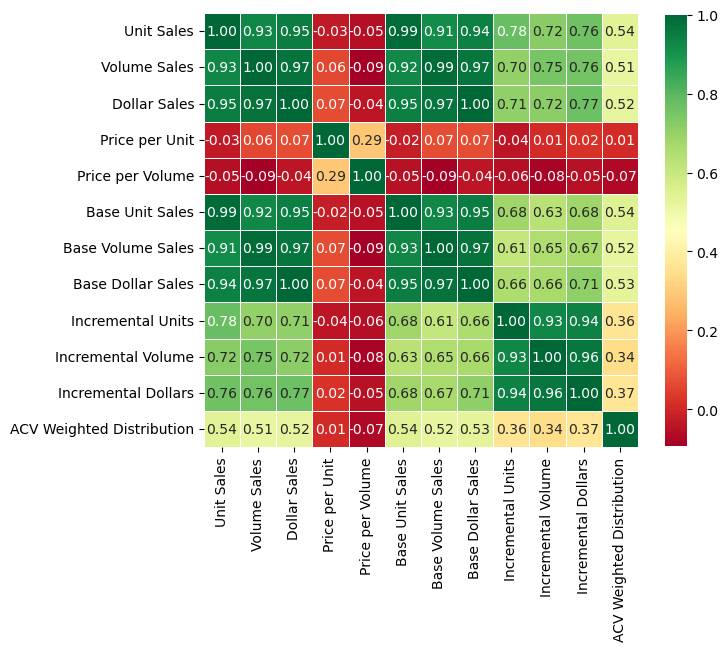

In [18]:
corrmat = combined[numeric_col].corr().round(2)
top_corr_features = corrmat.index
plt.figure(figsize=(7, 7))
sns.heatmap(combined[top_corr_features].corr(),annot=True, square=True, fmt='.2f',
            cbar_kws={"shrink": .80}, linewidths=.5, cmap='RdYlGn');

In [19]:
output_file = '/Users/fuqiaozhi/Desktop/UTD Semesters/Spring 2024/BUAN 6337/test_merge.csv'
combined.to_csv(output_file, index=False)

In [21]:
combined.columns

Index(['Geography', 'Year', 'Quarter', 'Month', 'Season', 'Manufacturer Name',
       'Brand Name', 'Product Name', 'Flavor / Scent', 'Meat Source',
       'Unit Sales', 'Volume Sales', 'Dollar Sales', 'Price per Unit',
       'Price per Volume', 'Base Unit Sales', 'Base Volume Sales',
       'Base Dollar Sales', 'Incremental Units', 'Incremental Volume',
       'Incremental Dollars', 'ACV Weighted Distribution'],
      dtype='object')

In [34]:
brand_sales.reset_index()

,Brand Name,Dollar Sales
0,MORNINGSTAR FARMS,4.374692e+08
1,IMPOSSIBLE,3.411279e+08
2,GARDEIN,1.805637e+08
3,GARDEIN ULTIMATE PLANT BASED,1.003873e+08
4,BEYOND MEAT,9.097650e+07
5,PRIVATE LABEL,8.165333e+07
6,BEYOND MEAT BEYOND BURGER,8.150699e+07
7,TOFURKY,8.041961e+07
8,FIELD ROAST,6.277077e+07
9,BEYOND MEAT BEYOND SAUSAGE,4.991420e+07


<Figure size 1000x800 with 0 Axes>

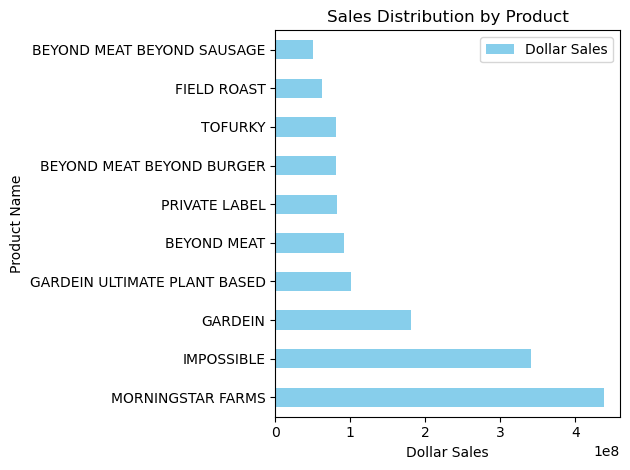

In [40]:
# Sales Distribution: Analyze the distribution of dollar sales across different manufacturers and brands to see which are the most popular or profitable.
brand_sales = combined.groupby('Brand Name').agg({'Dollar Sales':'sum'}).sort_values('Dollar Sales', ascending = False).head(10)
#sns.barplot(data = brand_sales, x = 'Brand Name', y = 'Dollar Sales')
plt.figure(figsize=(10, 8))
brand_sales.plot(kind='barh', color='skyblue')
plt.title('Sales Distribution by Product')
plt.xlabel('Dollar Sales')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()

In [41]:
# Price Analysis: Study the price per unit to understand pricing strategies or to identify if there's a correlation between price and sales volume.
price_descriptive_stats = combined['Price per Unit'].describe()
print(price_descriptive_stats)

# Distribution of 'Price per Unit'
plt.figure(figsize=(10, 6))
sns.histplot(combined['Price per Unit'], kde=True)
plt.title('Distribution of Price per Unit')
plt.xlabel('Price per Unit')
plt.ylabel('Frequency')
plt.show()

# Boxplot for 'Price per Unit'
plt.figure(figsize=(10, 6))
sns.boxplot(x=combined['Price per Unit'])
plt.title('Boxplot of Price per Unit')
plt.xlabel('Price per Unit')
plt.show()

# Correlation analysis
correlation_matrix = combined[['Price per Unit', 'Dollar Sales']].corr()
print(correlation_matrix)

# Scatter plot of 'Price per Unit' vs 'Dollar Sales'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined, x='Price per Unit', y='Dollar Sales')
plt.title('Price per Unit vs Dollar Sales')
plt.xlabel('Price per Unit')
plt.ylabel('Dollar Sales')
plt.show()

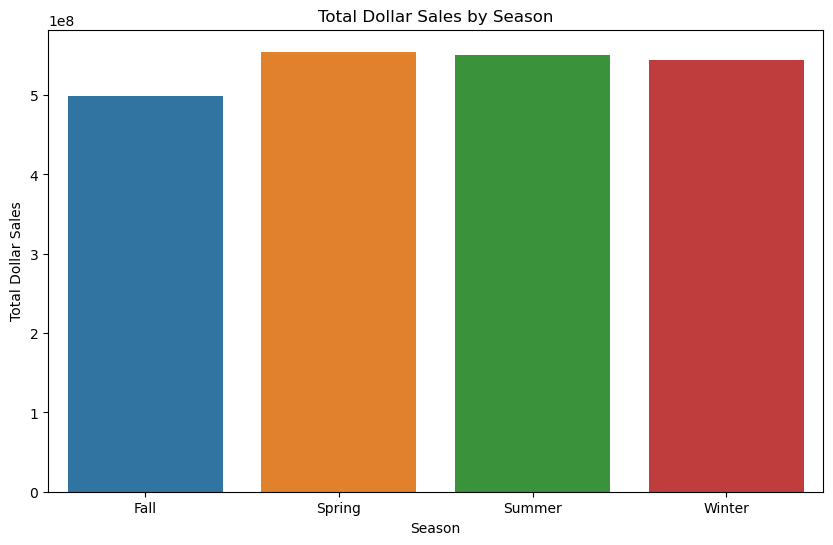

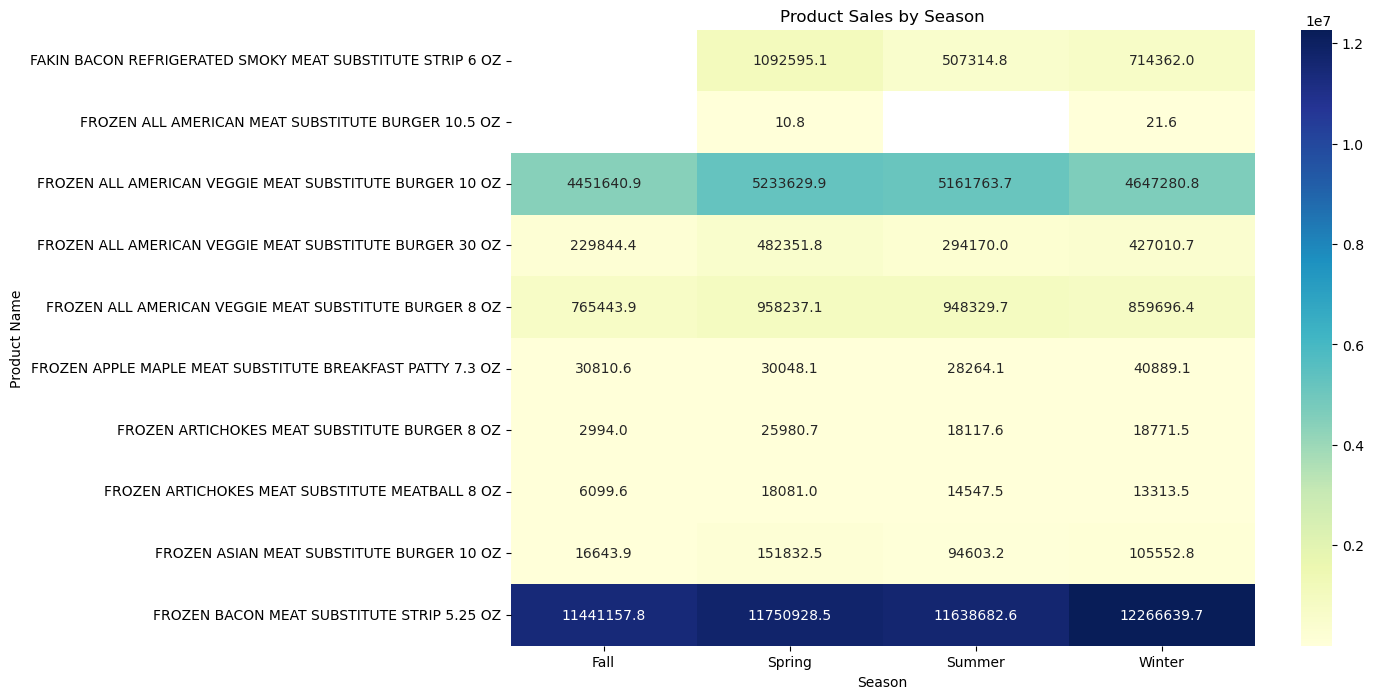

In [46]:
# Seasonality: Since the data includes a 'Season' column, you can examine seasonal trends in sales to determine if certain products sell better in certain seasons.
# Step 1: Aggregate Sales by Season
seasonal_sales = combined.groupby('Season')['Dollar Sales'].sum().reset_index()

# Step 2: Visualize Sales Trends by Season
plt.figure(figsize=(10, 6))
sns.barplot(data=seasonal_sales, x='Season', y='Dollar Sales')
plt.title('Total Dollar Sales by Season')
plt.xlabel('Season')
plt.ylabel('Total Dollar Sales')
plt.show()

# Step 3: Compare Product Performance by Season
product_seasonal_sales = combined.groupby(['Season', 'Product Name'])['Dollar Sales'].sum().reset_index()

# Creating a pivot table for better visualization
pivot_table = product_seasonal_sales.pivot(index='Product Name', columns='Season', values='Dollar Sales').head(10)

# Visualizing with a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Product Sales by Season')
plt.xlabel('Season')
plt.ylabel('Product Name')
plt.show()
# Geographical Analysis: The 'Geography' column can be used to determine regional preferences or sales performance.
# Time Series Analysis: Use the 'Year', 'Quarter', and 'Month' columns to perform a time series analysis to see sales trends over time.
# Product Mix Analysis: Evaluate which products (Product Name, Flavor/Scent) are the strongest performers in terms of unit volume and dollar sales.
# Variety and Size Impact: Compare the performance of different sizes and varieties (like 4 CT 16 OZ vs. 20 CT 4 OZ) of the same product to see if there's a notable preference.
# Correlation Analysis: Check for correlations between variables, such as price and sales volume, to understand the relationship between them.
# Market Share Analysis: Calculate the market share of each brand or manufacturer based on sales volume or dollar sales.
# Profitability Analysis: If cost data is available, analyze profitability by comparing sales to costs.
# Category Performance: Group products into categories (like 'REFRIGERATED BEEF') and compare their performance.

In [1]:
# test git new